# Setup
## Import libraries

In [3]:
import sys
import os
notebook_dir = os.getcwd()
root = os.path.abspath(os.path.join(notebook_dir, '../../'))
sys.path.append(root)
from utils.data.csv_parsing import load_csv_as_dicts, load_csv_as_dataframe
import getpass
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from langchain_anthropic import ChatAnthropic
from langsmith import Client
from langsmith.run_trees import RunTree
import pandas as pd


## Load Data

In [17]:
article_path = '/data/transformed/FA-KES.csv'

articles = load_csv_as_dicts(root+article_path)
articles_df = load_csv_as_dataframe(root+article_path)

In [18]:
articles_df[['labels','label']]

,labels,label
0,0,Fake
1,0,Fake
2,0,Fake
3,0,Fake
4,0,Fake
...,...,...
799,1,Credible
800,1,Credible
801,0,Fake
802,1,Credible


## Load API Keys

In [5]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "TRUE"
os.environ["LANGCHAIN_PROJECT"] = "FakeNews Detection - Zero Shot"

# Client

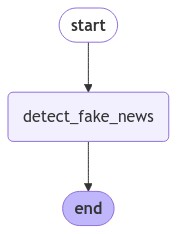

In [12]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
graph_builder = StateGraph(State)

class MisinformationOutputParser:
    def parse(self, response_content: str) -> dict:
        # Example of expected response format:
        # True or False followed by explanation:
        # "True: The article appears factual."
        # "False: The article contains misleading information because..."
        
        if "True" in response_content:
            label = False
        elif "False" in response_content:
            label = True
        else:
            raise ValueError("Unexpected response format")
        
        explanation = response_content.split(':', 1)[1].strip() if ':' in response_content else "No explanation provided"
        
        return {"label": label, "explanation": explanation}

class ZeroShotMisinformationDetector:
    def __init__(self, model_name="claude-3-haiku-20240307", project_name="fake_news_detection"):
        self.llm = ChatAnthropic(model=model_name)
        self.client = Client()
        self.project_name = project_name
        self.output_parser = MisinformationOutputParser()  # Initialize the parser

    def detect(self, article: dict) -> dict:
        article_title = article.get('article_title', '')
        article_content = article.get('article_content', '')

        # Define the system message
        system_message = {
            "role": "system",
            "content": (
                "You are a fact-checking expert. Evaluate the following news article for accuracy. "
                "If the article appears factual, respond with 'Credible'. If any part seems misleading or false, "
                "respond with 'Fake' and provide a brief explanation."
            )
        }

        user_message = {
            "role": "user",
            "content": f"Title: {article_title}\n\nContent: {article_content}"
        }

        # Create a RunTree instance for the run
        run_tree = RunTree(
            name=f"Detection_{article['unit_id']}",
            run_type="llm",
            inputs={"article_title": article_title, "article_content": article_content},
        )

        # Invoke the LLM
        response = self.llm.invoke([system_message, user_message])

        response_content = response.content

        # Use the output parser to process the response
        parsed_result = self.output_parser.parse(response_content)

        # End the run and log the outputs
        run_tree.end(outputs={
            "is_misinformation": parsed_result["is_misinformation"],
            "details": parsed_result["explanation"]
        })

        # Post the run to log it in Langsmith
        run_tree.post()

        return parsed_result

detector = ZeroShotMisinformationDetector()

def detect_misinformation(state: State):
    article = state["messages"][-1]  # Assuming the article is the last message
    detection_result = detector.detect(article)
    return {"messages": [detection_result['details']]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("detect_fake_news", detect_misinformation)
graph_builder.add_edge(START, "detect_fake_news")
graph_builder.add_edge("detect_fake_news", END)
graph = graph_builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print(Exception.with_traceback())
    pass

In [13]:
results = []
for article in articles[:2]:
    print(article)
    detection_result = detector.detect(article)
    results.append(detection_result)

# Print or store the results
for idx, result in enumerate(results):
    print(f"Article {idx + 1} Result: {result}")

{'unit_id': '1914947530', 'article_title': 'Syria attack symptoms consistent with nerve agent use WHO', 'article_content': 'Wed 05 Apr 2017 Syria attack symptoms consistent with nerve agent use WHO. Victims of a suspected chemical attack in Syria appeared to show symptoms consistent with reaction to a nerve agent the World Health Organization said on Wednesday. "Some cases appear to show additional signs consistent with exposure to organophosphorus chemicals a category of chemicals that includes nerve agents" WHO said in a statement putting the death toll at at least 70. The United States has said the deaths were caused by sarin nerve gas dropped by Syrian aircraft. Russia has said it believes poison gas had leaked from a rebel chemical weapons depot struck by Syrian bombs. Sarin is an organophosporus compound and a nerve agent. Chlorine and mustard gas which are also believed to have been used in the past in Syria are not. A Russian Defence Ministry spokesman did not say what agent wa

In [7]:
from pydantic import BaseModel

class MisinformationOutput(BaseModel):
    is_misinformation:  Annotated[bool, ..., "Whether the article is misinformation (True) or credible (False)"]
    explanation:  Annotated[str, ..., "Reasoning behind the classification"]

from langchain.output_parsers import PydanticOutputParser

In [8]:
from langsmith.run_helpers import traceable
from langchain_core.prompts import ChatPromptTemplate


In [9]:
dataset_name = "FA-KES"

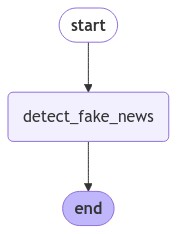

In [10]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
graph_builder = StateGraph(State)

class ZeroShotMisinformationDetector:
    def __init__(self, model_name="claude-3-haiku-20240307", project_name="fake_news_detection"):
        self.llm = ChatAnthropic(model=model_name)
        self.client = Client()
        self.project_name = project_name

    # You can add tags and metadata (or even the project name) directly in the decorator
    @traceable(
        run_type="chain",
        name=f"ZeroShot_{dataset_name}",
        tags=["tutorial"],
        metadata={"githash": "e38f04c83"},
        project_name="fake_news_detection"
    )
    def detect(self, article: dict) -> dict:
        article_title = article.get('article_title', '')
        article_content = article.get('article_content', '')

        # Define the system message
        system_message = """
                You are a fact-checking expert. Evaluate the following news article for accuracy. 
                If the article appears factual, respond with '1'. If any part seems misleading or false, 
                respond with '0' and provide a brief explanation.
        """


        prompt = ChatPromptTemplate.from_messages([("system", system_message), ("human","{input}")])
        
        # Invoke the LLM
        structured_llm = self.llm.with_structured_output(MisinformationOutput, include_raw=True)
        zero_shot_structured_llm = prompt | structured_llm
        result = zero_shot_structured_llm.invoke(f"Title: {article_title}\n\nContent: {article_content}")

        return result

detector = ZeroShotMisinformationDetector()

def detect_misinformation(state: State):
    article = state["messages"][-1]  # Assuming the article is the last message
    detection_result = detector.detect(article)
    return {"messages": [detection_result['details']]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("detect_fake_news", detect_misinformation)
graph_builder.add_edge(START, "detect_fake_news")
graph_builder.add_edge("detect_fake_news", END)
graph = graph_builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print(Exception.with_traceback())
    pass

In [11]:
results = []
for article in articles[:2]:
    print(article)
    detection_result = detector.detect(article)
    results.append(detection_result)

# Print or store the results
for idx, result in enumerate(results):
    print(f"Article {idx + 1} Result: {result}")

{'unit_id': '1914947530', 'article_title': 'Syria attack symptoms consistent with nerve agent use WHO', 'article_content': 'Wed 05 Apr 2017 Syria attack symptoms consistent with nerve agent use WHO. Victims of a suspected chemical attack in Syria appeared to show symptoms consistent with reaction to a nerve agent the World Health Organization said on Wednesday. "Some cases appear to show additional signs consistent with exposure to organophosphorus chemicals a category of chemicals that includes nerve agents" WHO said in a statement putting the death toll at at least 70. The United States has said the deaths were caused by sarin nerve gas dropped by Syrian aircraft. Russia has said it believes poison gas had leaked from a rebel chemical weapons depot struck by Syrian bombs. Sarin is an organophosporus compound and a nerve agent. Chlorine and mustard gas which are also believed to have been used in the past in Syria are not. A Russian Defence Ministry spokesman did not say what agent wa

In [12]:
results[1]['parsed']

{'explanation': 'The article appears to be factual and does not contain any misleading or false information. It reports on statements made by the Homs governor regarding the U.S. missile strike on a Syrian airbase, including his assessment that there were deaths but no "big human casualties". The article also provides context on the U.S. rationale for the strike and the Syrian government\'s denial of responsibility for the chemical weapons attack.',
 'is_misinformation': 'False'}

In [14]:
articles_df.head()

,unit_id,article_title,article_content,source,date,location,labels,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,1914947530,Syria attack symptoms consistent with nerve ag...,Wed 05 Apr 2017 Syria attack symptoms consiste...,nna,4/5/2017,idlib,0,NaN,NaN,NaN,NaN
1,1914947532,Homs governor says U.S. attack caused deaths b...,Fri 07 Apr 2017 at 0914 Homs governor says U.S...,nna,4/7/2017,homs,0,NaN,NaN,NaN,NaN
2,1914947533,Death toll from Aleppo bomb attack at least 112,Sun 16 Apr 2017 Death toll from Aleppo bomb at...,nna,4/16/2017,aleppo,0,NaN,NaN,NaN,NaN
3,1914947534,Aleppo bomb blast kills six Syrian state TV,Wed 19 Apr 2017 Aleppo bomb blast kills six Sy...,nna,4/19/2017,aleppo,0,NaN,NaN,NaN,NaN
4,1914947535,29 Syria Rebels Dead in Fighting for Key Alepp...,Sun 10 Jul 2016 29 Syria Rebels Dead in Fighti...,nna,7/10/2016,aleppo,0,NaN,NaN,NaN,NaN


In [16]:
client = Client()

In [17]:
input_keys = ['unit_id', 'article_title','article_content','source','date','location']
output_keys = ['labels']

dataset = client.upload_dataframe(
    df=articles_df,
    input_keys=input_keys,
    output_keys=output_keys,
    name="FA-KES",
    description="FA-KES Syrian War dataset",
    data_type="kv" # The default
)

In [16]:
from langsmith.schemas import Example, Run

def correct_label(root_run: Run, example: Example) -> dict:
    score = root_run.outputs.get("output") == example.outputs.get("label")
    return {"score": int(score), "key": "correct_label"}



In [ ]:
from langsmith.evaluation import evaluate

dataset_name = "Toxic Queries"

results = evaluate(
    lambda inputs: label_text(inputs["text"]),
    data=dataset_name,
    evaluators=[correct_label],
    experiment_prefix="Toxic Queries",
    description="Testing the baseline system.",  # optional
)